In [3]:
# ----- Make a Synthetic video file and displays it ---------
import numpy as np
import cv2

# Parameters
frame_size = (200, 200)
num_frames = 30
square_size = 20
motion_vector = (5, 5)  # Movement per frame (x, y)

# Create synthetic video
video = np.zeros((num_frames, frame_size[0], frame_size[1]), dtype=np.uint8)
for i in range(num_frames):
    x_start = motion_vector[0] * i
    y_start = motion_vector[1] * i
    x_end = x_start + square_size
    y_end = y_start + square_size
    video[i, y_start:y_end, x_start:x_end] = 255  # Moving square

# Save the video to a file
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('synthetic_video.avi', fourcc, 10.0, (frame_size[1], frame_size[0]), False)
for i in range(num_frames):
    frame = video[i]
    out.write(frame)
out.release()

# Display the synthetic video
for i in range(num_frames):
    frame = video[i]
    cv2.imshow('Frame', frame)
    cv2.waitKey(100)  # Wait for 100 ms between frames

cv2.destroyAllWindows()

# Note: The motion estimation and display part is omitted for brevity, assuming it's implemented as before.


/var/folders/fz/_4_3bkv156zfzhgs_qdg_3rw0000gp/T/ipykernel_9214/3848982596.py:25: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  vectors = np.zeros((h // block_size, w // block_size, 2), dtype=np.int)


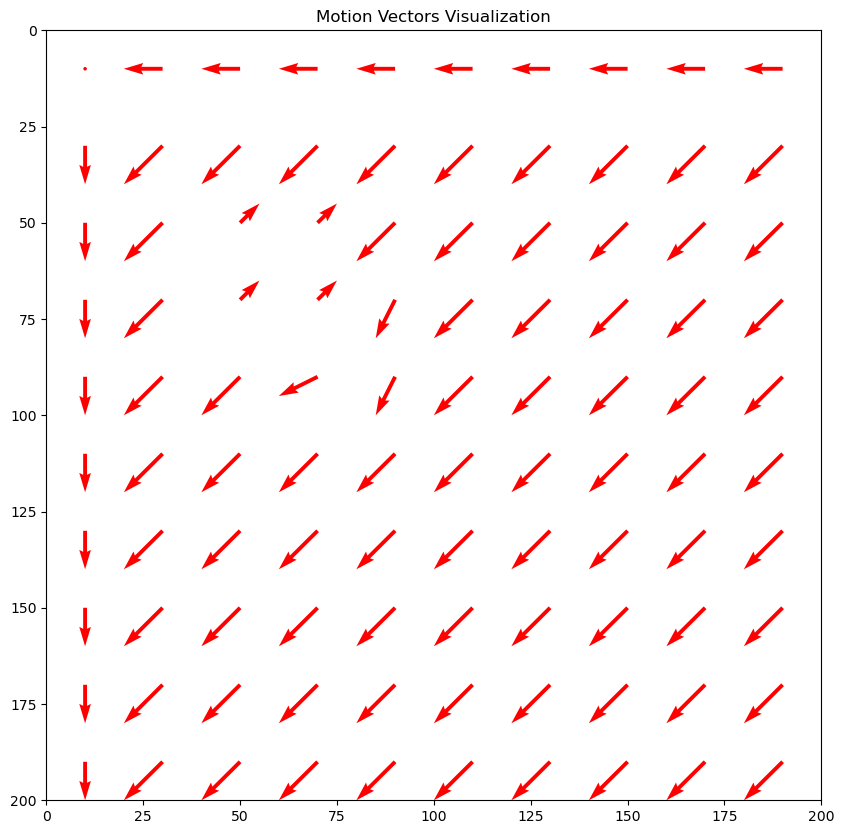

In [13]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Parameters
frame_size = (200, 200)
num_frames = 30
square_size = 20
motion_vector = (5, 5)  # Movement per frame (x, y)

# Create synthetic video
video = np.zeros((num_frames, frame_size[0], frame_size[1]), dtype=np.uint8)
for i in range(num_frames):
    x_start = motion_vector[0] * i
    y_start = motion_vector[1] * i
    x_end = x_start + square_size
    y_end = y_start + square_size
    video[i, y_start:y_end, x_start:x_end] = 255  # Moving square
    
    
    
# Simple motion estimation (block matching)
def estimate_motion(previous_frame, current_frame, block_size=20, search_area=10):
    h, w = previous_frame.shape
    vectors = np.zeros((h // block_size, w // block_size, 2), dtype=np.int)
    
    for y in range(0, h, block_size):
        for x in range(0, w, block_size):
            best_match = (0, 0)
            min_diff = np.inf
            
            for dy in range(-search_area, search_area + 1):
                for dx in range(-search_area, search_area + 1):
                    if 0 <= x + dx < w - block_size and 0 <= y + dy < h - block_size:
                        diff = np.sum(np.abs(previous_frame[y:y+block_size, x:x+block_size] -
                                              current_frame[y+dy:y+dy+block_size, x+dx:x+dx+block_size]))
                        if diff < min_diff:
                            min_diff = diff
                            best_match = (dx, dy)
            
            vectors[y // block_size, x // block_size] = best_match
    
    return vectors

# Example of motion estimation between the first two frames
vectors = estimate_motion(video[10], video[11], block_size=20, search_area=10)

# Display motion vectors
# plt.quiver(np.arange(0, frame_size[1], 20), np.arange(0, frame_size[0], 20),
#            vectors[:,:,0], -vectors[:,:,1], angles='xy', scale_units='xy', scale=1)
# plt.gca().invert_yaxis()
# plt.show()


# Prepare for visualization
# Calculate the midpoint of blocks to plot vectors accurately
mid_point = 20 // 2  # Assuming block_size is 20
X, Y = np.meshgrid(np.arange(mid_point, frame_size[1], 20), np.arange(mid_point, frame_size[0], 20))

# Directly use vectors for drawing, ensuring their visibility
plt.figure(figsize=(10, 10))  # Increase figure size for clarity
Q = plt.quiver(X, Y, vectors[:, :, 0], -vectors[:, :, 1], angles='xy', scale_units='xy', scale=1, color='r', width=0.005)

plt.gca().set_xlim([0, frame_size[1]])
plt.gca().set_ylim([0, frame_size[0]])
plt.gca().invert_yaxis()  # Match the image coordinate system

plt.title('Motion Vectors Visualization')
plt.show()


In [14]:
pip install opencv-python opencv-python-headless


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 MB 18.4 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
import cv2
import numpy as np

def compute_dense_optical_flow(video_path, output_path):
    cap = cv2.VideoCapture(video_path)
    
    # Check if video opened successfully
    if not cap.isOpened():
        print("Error opening video file")
        return
    
    # Get video properties for the output file
    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))
    
    # Read the first frame
    ret, prev_frame = cap.read()
    if not ret:
        print("Failed to read video")
        cap.release()
        return
    
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    
    # Create a mask image for drawing the optical flow
    hsv_mask = np.zeros_like(prev_frame)
    hsv_mask[..., 1] = 255

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Compute the dense optical flow
        flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        
        # Convert flow to polar coordinates
        mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
        hsv_mask[..., 0] = ang * 180 / np.pi / 2
        hsv_mask[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
        
        # Convert HSV to RGB to display
        bgr = cv2.cvtColor(hsv_mask, cv2.COLOR_HSV2BGR)
        
        # Write the frame
        out.write(bgr)
        
        cv2.imshow('Dense Optical Flow', bgr)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        
        # Update the previous frame and previous gray
        prev_gray = gray

    cap.release()
    out.release()
    cv2.destroyAllWindows()

# Usage example
video_path = '/Users/reza/EVERYTHING/Work/ML Book/Figs/CH6/24-4.mp4'
output_path = '/Users/reza/EVERYTHING/Work/ML Book/Figs/dense_optical_flow_output.avi'
compute_dense_optical_flow(video_path, output_path)



In [7]:
import cv2
import numpy as np

def compute_sparse_optical_flow(video_path, output_path):
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print("Error opening video file")
        return
    
    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))
    
    # Parameters for ShiTomasi corner detection
    feature_params = dict(maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)
    
    # Parameters for Lucas-Kanade optical flow
    lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
    
    # Take the first frame and find corners in it
    ret, old_frame = cap.read()
    if not ret:
        print("Failed to read video")
        cap.release()
        return
    
    old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
    p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params)
    
    # Create a mask image for drawing purposes
    mask = np.zeros_like(old_frame)
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # calculate optical flow
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
        
        if p1 is not None:
            good_new = p1[st == 1]
            good_old = p0[st == 1]
            
            # draw the tracks
            for i, (new, old) in enumerate(zip(good_new, good_old)):
                a, b = new.ravel()
                c, d = old.ravel()
                
                # Ensure the points are in the correct format
                a, b, c, d = int(a), int(b), int(c), int(d)
                
                mask = cv2.line(mask, (a, b), (c, d), (0, 255, 0), 2)
                frame = cv2.circle(frame, (a, b), 5, (0, 0, 255), -1)
        else:
            print("No points to track.")

        img = cv2.add(frame, mask)
        
        # Write the frame
        out.write(img)
        
        cv2.imshow('frame', img)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        
        # Now update the previous frame and previous points
        old_gray = frame_gray.copy()
        if p1 is not None and len(p1[st == 1]) > 0:
            p0 = good_new.reshape(-1, 1, 2)
    cap.release()
    out.release()
    cv2.destroyAllWindows()

# Usage example
video_path = '/Users/reza/EVERYTHING/Work/ML Book/Figs/CH6/24-4.mp4'
output_path = '/Users/reza/EVERYTHING/Work/ML Book/Figs/sparse_optical_flow_output.avi'
compute_sparse_optical_flow(video_path, output_path)
